# Final Project Submission
 - Student name: Morgan Jones
 - Student pace: Full Time
 - Scheduled project review date/time:
 - Instructor name: Abhineet Kulkarni
 - Blog post URL: 

# Introduction 
***


##### **Disclaimer**

This work is meant to fulfill educational purposes. The hypothetical business case, and results of modeling are not meant to be considered as medical advise, and has not been approved by any professional or medical body.

## Business Case

As of May 4, 2020 COVID-19 has had devastating impacts on the world. To date, there are over 3.5 million confirmed cases in roughly a 5 month window of time. While there are several factors that have led to these disheartening statistics, one key element in this proliferation is travel. Due to the often asymptomatic nature of COVID-19 infections, infected individuals have been able to unknowingly spread the virus to over 200 countries and territories. 
In order to 'flatten the curve' my group would like to **propose a systematic approach to implementing non-invasive testing at key international airports that would identify and quarantine would be infected travelers**. Our proposal is simple, through effective risk mapping and assessment driven by data, high risk travelers' lungs are scanned with computed tomography (CT), and the resulting **x-ray images are assessed with a Convolutional Neural Network trained on detecting COVID-19**. Those travelers identified by the neural network as infected would then be further tested by medical professionals before being approved for travel. **This project focuses on the creation and optimization of this COVID-19 detecting CNN**.

## Objectives

There are two main objectives for this portion of the aforementioned proposal, which are as follows:
 1. Generate a Convolutional Neural Network (CNN) which detects the presence of COVID-19 in CT images with a **high** accuracy.
 2. Reveal potential indicators of COVID-19 through analysis of said CNN.

## Evaluation Metrics

Our task is essentially a binary classification problem, where an x-ray image is considered input, and **our model produces an prediction of whether this image is of a COVID-19 infected lung, or is not**. With these objectives and framework in mind, the threshold of success mainly rests on the accuracy of our model. We will set the goal of our model attaining **at least an 80% accuracy**. With accuracy here being defined as:

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

Then our model will be successful where:

$$Accuracy >= .80$$


In the case where our model predicts incorrectly, we **prefer a false positive more than a false negative**. In the case of a false positive, a traveler is determined as infected where they are not. In this case that person would be held for further testing, potentially missing their flight. However **in the case of a false negative, our model has determined that an image of lungs that are COVID-19 infected are not, and thus that traveler would continue on potentially infecting others**. Therefore we aim for a model that meets the most recent standards as defined by the FDA for Covid-19 tests:

"Tests should accurately identify at least 90% of positive cases (what epidemiologists call sensitivity) and 95% of negative cases (specificity)."

For our model's evaluation this is further defined as:


$$ \text{Precision} = \frac{\text{Number of True Positives}}{\text{Number of Predicted Positives}} $$

  

$$ \text{Recall} = \frac{\text{Number of True Positives}}{\text{Number of Actual Total Positives}} $$

Our model will achieve:

$$ \text{Recall}  >= .90 $$


## Methodology

The process for conducting our research and modeling will follow the iterative **OSEMiN** pipeline. This entails Obtaining, Scrubbing, Exploring, Modeling, and Interpreting the data. This project will use this pipeline in the following manner: 

**OSEMiN Pipeline**:

    Obtain
    - Import the data.

    Scrub
    - Manage datatypes, resolve missing/duplicate values.
    
    Explore
    - Find patterns among the relationships of variables in the dataset.
    
    Model
    - Create predictive models.
    
    iNterpret
    – Identify insights and visualize findings.

# Obtain
***

At this stage, there is a limited amount of data pertaining to CT scans of COVID-19 cases available openly with respect to the amount effective when conducting deep learning. However this will not deter us in pursuing the objectives we have set. In order to begin, we will need to obtain this data, and the libraries needed for this project.

## Import Libraries

There are several libraries that we will import for the purposes of our project. There will be the most essential libraries useful for manipulating and importing our necessary data. For working with neural networks we will work with keras with a tensorflow backend. We can import these libraries as follows:

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2, time
import datetime
import os
import math 
import tensorflow as tf

tf.__version__ # Check version of tensorflow

'1.15.0'

In [2]:
# Import libraries for keras neural network implementation
from keras import models
from keras import layers
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

Using TensorFlow backend.


In [3]:
# Check device usage for notebook, namely check for GPU Usage
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17824288804185524987
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8735979358269622418
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# Import metrics modules for checking and visualizing performance of models
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [5]:
# from keras.utils.vis_utils import plot_model to display Neural Networks
from tensorflow.keras.utils import plot_model

In [6]:
# Split and encode data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [7]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

## Import Covid-19 Data

The data that will be used for our model has been graciously prepared by Casper Hansen in conjunction with the IBM 2020 Call for Code Global Challenge in an initiative against the spread of Covid-19. His code is featured here https://developer.ibm.com/articles/using-deep-learning-to-take-on-covid-19/ , and on github: https://github.com/casperbh96/COVID-19-Detection/blob/master/Deep_Learning_for_COVID_19.ipynb . We will use the processed CT images hosted by Casper for our neural networks. In order to access these data we will download it directly to our local hardware, and create a path to the images like so:

In [8]:
# Create a path for the covid-positive data
covid_path = 'dataset/covid_dataset.csv'
covid_image_path = 'dataset/covid_adjusted/'

# Create a path for the covid-negative data
normal_path = 'dataset/normal_xray_dataset.csv'
normal_image_path = 'dataset/normal_dataset/'

# Create dataframes of the two types of images
covid_df = pd.read_csv(covid_path, usecols=['filename', 'finding'])
normal_df = pd.read_csv(normal_path, usecols=['filename', 'finding'])

### Data Description

Now with our data imported and stored in a pandas dataframe, we can take a brief look with the `.head()` and `.info()` methods. Let's check these dataframes now.

In [9]:
# Check the covid-negative dataframe
normal_df.head()

filename finding
0  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg  Normal
1  009482dc-3db5-48d4-8580-5c89c4f01334.jpg  Normal
2  009eb222-eabc-4150-8121-d5a6d06b8ebf.jpg  Normal
3  00a85be6-6eb0-421d-8acf-ff2dc0007e8a.jpg  Normal
4  00f87de5-5fe0-4921-93ea-914d7e683266.jpg  Normal

In [10]:
# Return the size and datatypes in the dataframe
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 2 columns):
filename    8583 non-null object
finding     8583 non-null object
dtypes: object(2)
memory usage: 134.2+ KB


Our covid-negative dataframe has a total of 8583 images, which for most neural network architectures is relatively low. Let's take a brief look at the covid-positive cases.

In [11]:
# Check the covid-positive dataframe
covid_df.head()

filename   finding
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  COVID-19
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...  COVID-19
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...  COVID-19
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...  COVID-19
4                          nejmc2001573_f1a.jpeg.jpg  COVID-19

In [12]:
# Check the 
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
filename    92 non-null object
finding     92 non-null object
dtypes: object(2)
memory usage: 1.6+ KB


We can see from the returns of the `.head()` and `.info()` for the covid-positive cases that there is a large bias in our data. We can visualize this easier with a seaborn countplot after creating a dataset including both the covid-positive and covid-negative cases with the pandas `.pd.concat()` method. We can do this now:

In [13]:
# Create complete dataframe of all data
df = pd.concat([normal_df, covid_df], axis=0)
# View first 5 cases of dataframe
df.head()

filename finding
0  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg  Normal
1  009482dc-3db5-48d4-8580-5c89c4f01334.jpg  Normal
2  009eb222-eabc-4150-8121-d5a6d06b8ebf.jpg  Normal
3  00a85be6-6eb0-421d-8acf-ff2dc0007e8a.jpg  Normal
4  00f87de5-5fe0-4921-93ea-914d7e683266.jpg  Normal

Now with our dataframe created, let's use `value_counts()` to view the counts of cases in our data. 

In [14]:
# View value counts in dataset
display(df['finding'].value_counts())
# View percentages of value counts in dataset
display(df['finding'].value_counts(normalize=True))

Normal      8583
COVID-19      92
Name: finding, dtype: int64

Normal      0.989395
COVID-19    0.010605
Name: finding, dtype: float64

Now we can create a seaborn countplot to visualize these values.

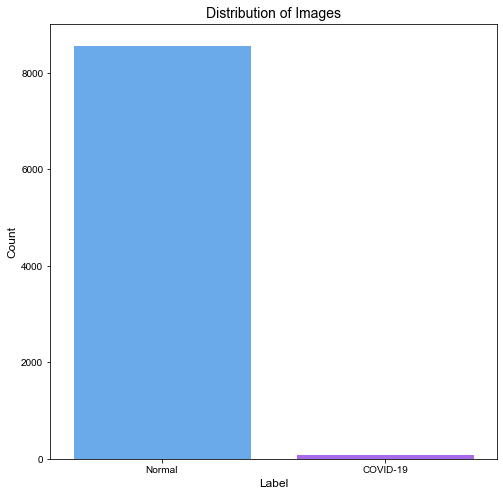

In [15]:
# Create a matplotlib figure and axis for countplot
fig, ax = plt.subplots(figsize=(8, 8))
# Set style of seaborn plot
sns.set_style('darkgrid')
# Create the countplot for findings in dataframe
ax = sns.countplot(df['finding'], palette='cool')   
# Create title for countplot
ax.set_title('Distribution of Images', fontsize=14)
# Create X-axis
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

There is a stark bias within our dataset. Nearly 99% of our data is covid-negative. For our networks this could prove to be quite challenging. Our model would be able to predict all of the cases as covid-negative and be 99% accurate, and this certainly is not a goal for our group. After this inspection, we can begin to create lists for the images and their labels so that our model understands what our target variable is.

In [16]:
normal_df = normal_df.head(99)

In [17]:
# Create complete dataframe of all data
df = pd.concat([normal_df, covid_df], axis=0)
# View first 5 cases of dataframe
df.head()

filename finding
0  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg  Normal
1  009482dc-3db5-48d4-8580-5c89c4f01334.jpg  Normal
2  009eb222-eabc-4150-8121-d5a6d06b8ebf.jpg  Normal
3  00a85be6-6eb0-421d-8acf-ff2dc0007e8a.jpg  Normal
4  00f87de5-5fe0-4921-93ea-914d7e683266.jpg  Normal

In [18]:
# View value counts in dataset
display(df['finding'].value_counts())
# View percentages of value counts in dataset
display(df['finding'].value_counts(normalize=True))

Normal      99
COVID-19    92
Name: finding, dtype: int64

Normal      0.518325
COVID-19    0.481675
Name: finding, dtype: float64

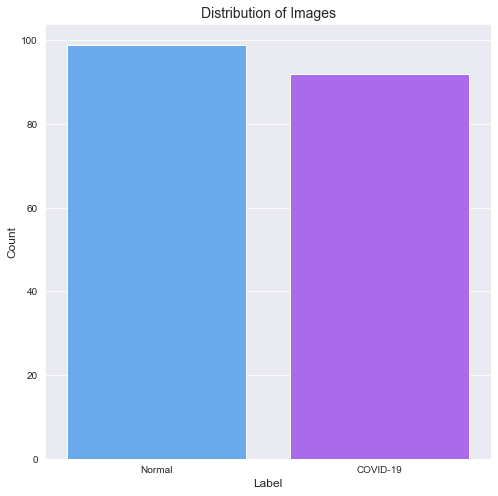

In [19]:
# Create a matplotlib figure and axis for countplot
fig, ax = plt.subplots(figsize=(8, 8))
# Set style of seaborn plot
sns.set_style('darkgrid')
# Create the countplot for findings in dataframe
ax = sns.countplot(df['finding'], palette='cool')   
# Create title for countplot
ax.set_title('Distribution of Images', fontsize=14)
# Create X-axis
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

# Scrub

Part of the outstanding work that Casper has conducted lies in his preprocessing of the images. In the original dataset, there was an overwhelming presence of black bars within the negative cases, which would be an irrelevant pattern that our model would observe and associate with presence of Covid-19. Casper was able to successfully find rows that are saturated with black pixels and remove them, as well as alter the aspect ratio of images so that both the covid-positive and covid-negative images appeared the same to the model. Our model will work with these already preprocessed images.

In [20]:
# Instantiate lists to hold images and their labels
covid_images = []
covid_labels = []

# Iterate through the rows within covid-positive data to retrieve the names
# of image and their labels and connect to the path of that image 
# in the directory 
for index, row in covid_df.iterrows():
    filename = row['filename']
    label = row['finding']
    path = covid_image_path + filename

    # further convert the pixel values of the images from BGR to RGB
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Append images and their labels to the appropriate lists
    covid_images.append(image)
    covid_labels.append(label)

In [21]:
# Instantiate lists to hold images and their labels
normal_images = []
normal_labels = []

# Iterate through the rows within covid-negative data to retrieve the names
# of image and their labels and connect to the path of that image 
# in the directory 
for index, row in normal_df.iterrows():
    filename = row['filename']
    label = row['finding']
    path = normal_image_path + filename

    # temporary fix while we preprocess ALL the images
    if filename == '4c268764-b5e5-4417-85a3-da52916984d8.jpg':
        break
 
    # further convert the pixel values of the images from BGR to RGB
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Append images and their labels to the appropriate lists
    normal_images.append(image)
    normal_labels.append(label)

In [22]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255

# normalize to interval of [0,1]
normal_images = np.array(normal_images) / 255

In [23]:
print('There are {} images in covid_images'.format(len(covid_images)))
print('There are {} images in normal_images'.format(len(normal_images)))

There are 92 images in covid_images
There are 99 images in normal_images


# Explore

Now that our data has been organized with the appropriate labels assigned to the images, we can view groupings of the images associated with positive covid-19 cases and negative covid-19 cases. Let's use a function that plots several images associated with their appropriate class.

In [24]:
# Create a function that plots images associated with a certain class
def plot_images(images, title):
    # Define the number of rows and columns of images
    nrows, ncols = 4, 4
    # Define the fig size
    figsize = [12, 10]
    
    # Instantiate a figure and axis for plots defined by previous variables
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
    
    # Iterate through images and plot them on the appropriate axis
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    # Create title and layout, show plot
    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

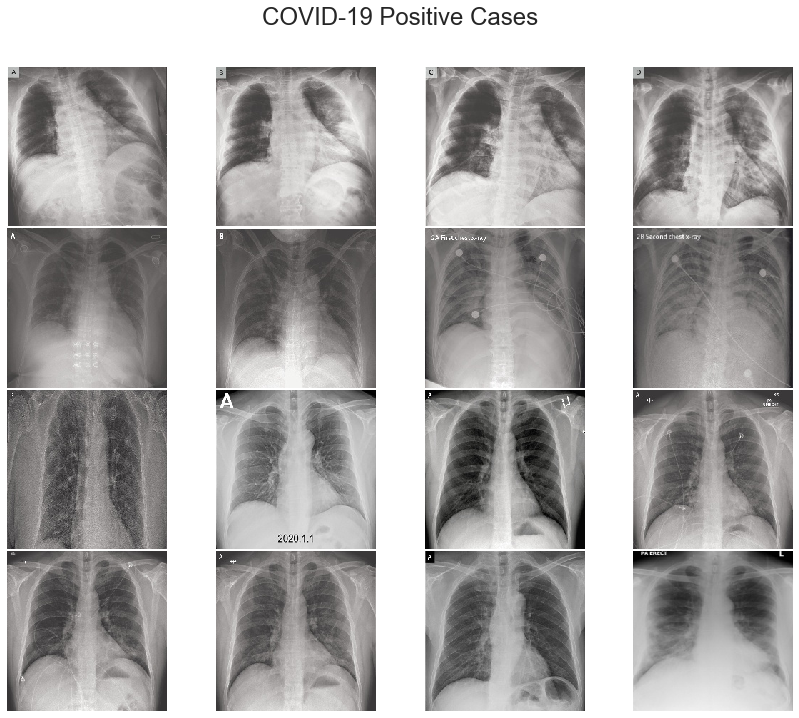

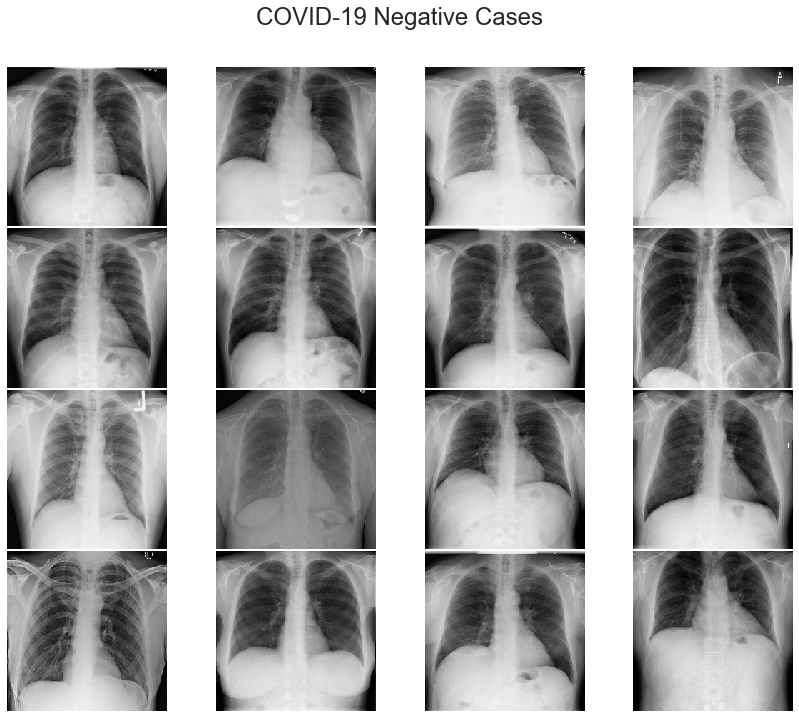

In [25]:
# Plot images for positive and negaive cases
plot_images(covid_images, 'COVID-19 Positive Cases')
plot_images(normal_images, 'COVID-19 Negative Cases')

We can now see a sample of images from both of our classes. However, there appear to be no clear patterns that can be gleamed from the human eye that can distinguish lungs infected with covid-19 and lungs that are not. Let's create a function that can help us visualize the pixel values within the images to get a better understanding of the patterns within the images.

In [26]:
# Create a function that plots pixel intensities
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    his = plt.subplot(1,2,2)
    his.set_ylabel('Count')
    his.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

Now we can use this function on a covid-positive image and a covid-negative image.

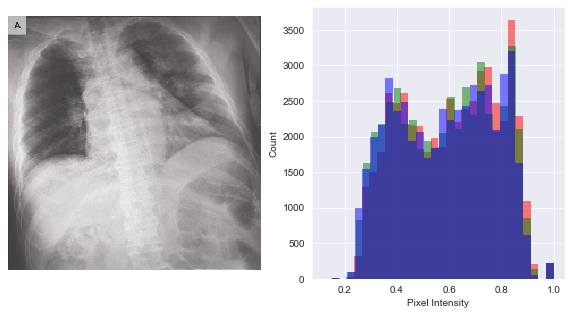

In [27]:
# Show image and histogram of pixel intensities
plotHistogram(covid_images[0])

We can see above the pixel intensities of the first image within the covid-positive group. The histogram shows us that the red, green, and blue pixels all have roughly the same distributions for this particular image. Let's apply the same function to an images within the covid-negative class.

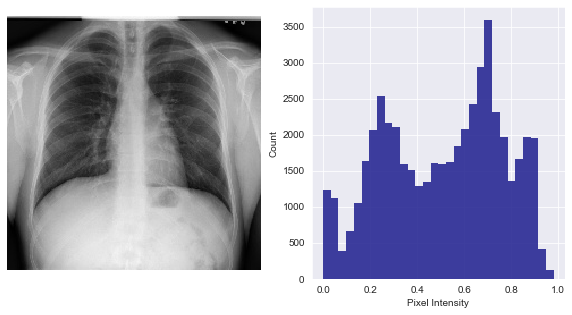

In [28]:
# Show image and histogram of pixel intensities
plotHistogram(normal_images[0])

For this particular image we can see that there is a grey scale, with pixel values ranging from 0(black) to 255(white). The distribution of the intensities appears to be slightly different than those of the covid-positive image we viewed. After this exploration, we can now begin to model our data.

# Model

In order to model our data, we will need to first split the data into train and test sets. Typically a validation set would be included in the split of our data, but with only 92 cases of positive images we will only use a train/test split. Our model will use 80% of the data for the training set, and 20% for the testing set. 

In [29]:
# split positve cases into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)

# split negative cases into training and testing
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)

In [30]:
# Create train and test datasets with negative and positive cases
X_train = np.concatenate((normal_x_train, covid_x_train), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test), axis=0)

In [31]:
# turn labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

# turn labels into categories - either 0 or 1
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

Now with our train/test sets created, let's view the length of the sets.

In [32]:
print('There are {} images in X_train'.format(len(X_train)))
print('There are {} images in X_test'.format(len(X_test)))
print('There are {} images in y_train'.format(len(y_train)))
print('There are {} images in y_test'.format(len(y_test)))

There are 152 images in X_train
There are 39 images in X_test
There are 152 images in y_train
There are 39 images in y_test


In [33]:
print('There are {} images in covid_x_train'.format(len(covid_x_train)))
print('There are {} images in covid_x_test'.format(len(covid_x_test)))
print('There are {} images in covid_y_train'.format(len(covid_y_train)))
print('There are {} images in covid_y_test'.format(len(covid_y_test)))

print('There are {} images in normal_x_train'.format(len(normal_x_train)))
print('There are {} images in normal_x_test'.format(len(normal_x_test)))
print('There are {} images in normal_y_train'.format(len(normal_y_train)))
print('There are {} images in normal_y_test'.format(len(normal_y_test)))

There are 73 images in covid_x_train
There are 19 images in covid_x_test
There are 73 images in covid_y_train
There are 19 images in covid_y_test
There are 79 images in normal_x_train
There are 20 images in normal_x_test
There are 79 images in normal_y_train
There are 20 images in normal_y_test


With that we are ready to begin modeling our data. The first model will be our baseline convolutional neural network. It will be a sequential model with 3 convolutional layers, maxpooling, and an output layer of 2 nodes, one for each class within our dataset. Our optimizer will be stochastic gradient descent and the learning rate will be the default value of 0.01. We can instantiate this model now and create its layers.

## Baseline CNN

In [34]:
# Create baseline model
base_model = models.Sequential()

# Add the appropriate layers
base_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='sigmoid'))

# Compile the model
base_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Now that our model has been created, we can check its shape using the `.summary()` method. This will output a description of our model along with the count for the parameters of the model.

In [35]:
# Return a summary of our model
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

We can also view a schematic of our model with the `plot_model()` method to get a better understanding of its shape.

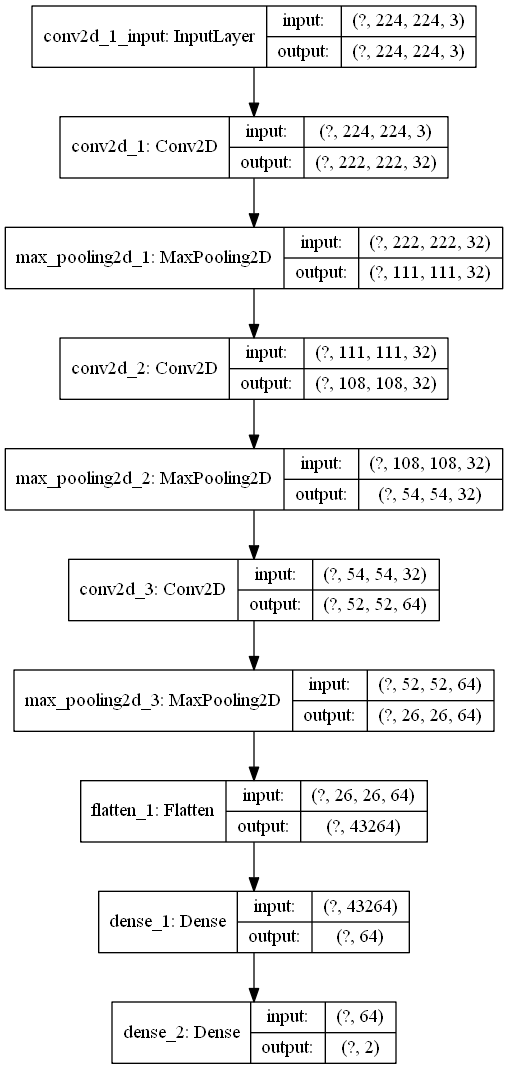

In [36]:
# Return image of model's architecture
plot_model(base_model, show_shapes=True, show_layer_names=True)

One of the key components of success for our model will be to generate more data for our model to train on. To this end we will use ImageDataGenerator to augment our data. Here we will rotate, shift, and flip our images in order to 'create' more data to help our model recognize important patterns in the data. After this augmentation, we will fit our model. 

In [37]:
# Generate augmented images
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit our model, and define the number of epochs and steps per epoch
history = base_model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    verbose=2,
                    epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
 - 5s - loss: 0.6966 - acc: 0.4803 - val_loss: 0.6917 - val_acc: 0.6923
Epoch 2/10
 - 1s - loss: 0.6939 - acc: 0.4868 - val_loss: 0.6913 - val_acc: 0.5385
Epoch 3/10
 - 2s - loss: 0.6926 - acc: 0.5263 - val_loss: 0.6904 - val_acc: 0.5128
Epoch 4/10
 - 2s - loss: 0.6933 - acc: 0.4934 - val_loss: 0.6900 - val_acc: 0.5128
Epoch 5/10
 - 2s - loss: 0.6936 - acc: 0.4803 - val_loss: 0.6904 - val_acc: 0.5128
Epoch 6/10
 - 2s - loss: 0.6925 - acc: 0.5197 - val_loss: 0.6895 - val_acc: 0.5128
Epoch 7/10
 - 2s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6896 - val_acc: 0.5128
Epoch 8/10
 - 2s - loss: 0.6928 - acc: 0.5066 - val_loss: 0.6897 - val_acc: 0.5128
Epoch 9/10
 - 2s - loss: 0.6921 - acc: 0.5132 - val_loss: 0.6888 - val_acc: 0.5128
Epoch 10/10
 - 2s - loss: 0.6943 - acc: 0.4868 - val_loss: 0.6886 - val_acc: 0.5128


In [38]:
# Create predictions for the model
y_pred = base_model.predict(X_test, batch_size=32)
y_pred_covid = base_model.predict(covid_x_test, batch_size=32)

In [39]:
# Encode the labels of our test data
y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

With our predictions made, we can analyze the results using a confusion matrix that will display the number of True Positives, True Negatives, False Positives, and False Negatives. Here we will understand if our model has met the standards we set in the evaluation metrics section of the notebook.

In [40]:
# Generate a confusion matrix displaying the performance of the model
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
cm

array([[ 0, 19],
       [ 0, 20]], dtype=int64)

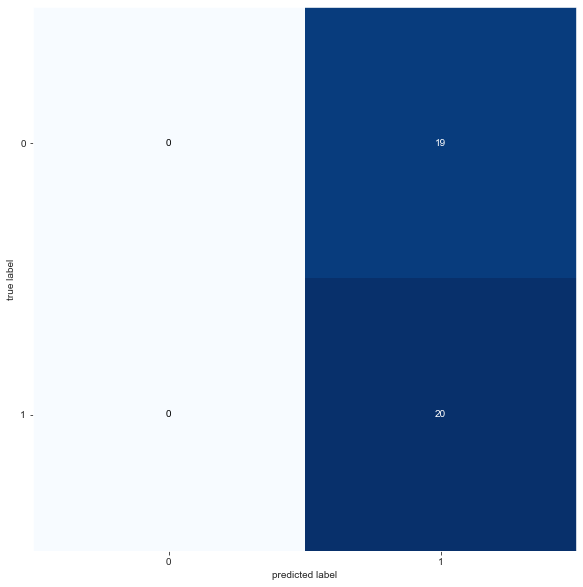

In [41]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 10))
plt.show()

We will also generate the classification report for our model which will display the precision, recall, and f1 score for each class of our model. It will also return the overall accuracy of our model.

In [42]:
# Generate classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.51      1.00      0.68        20

    accuracy                           0.51        39
   macro avg       0.26      0.50      0.34        39
weighted avg       0.26      0.51      0.35        39



C:\Users\morga\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that our baseline model completely ignored the covid-positive cases. Our model was able to understand that a high overall accuracy could be achieved by simply predicting every instance to be covid-negative. This model will serve no value for the purposes of our business case. We can plot the performance during the epochs of training for our model to assess how to improve its performance.

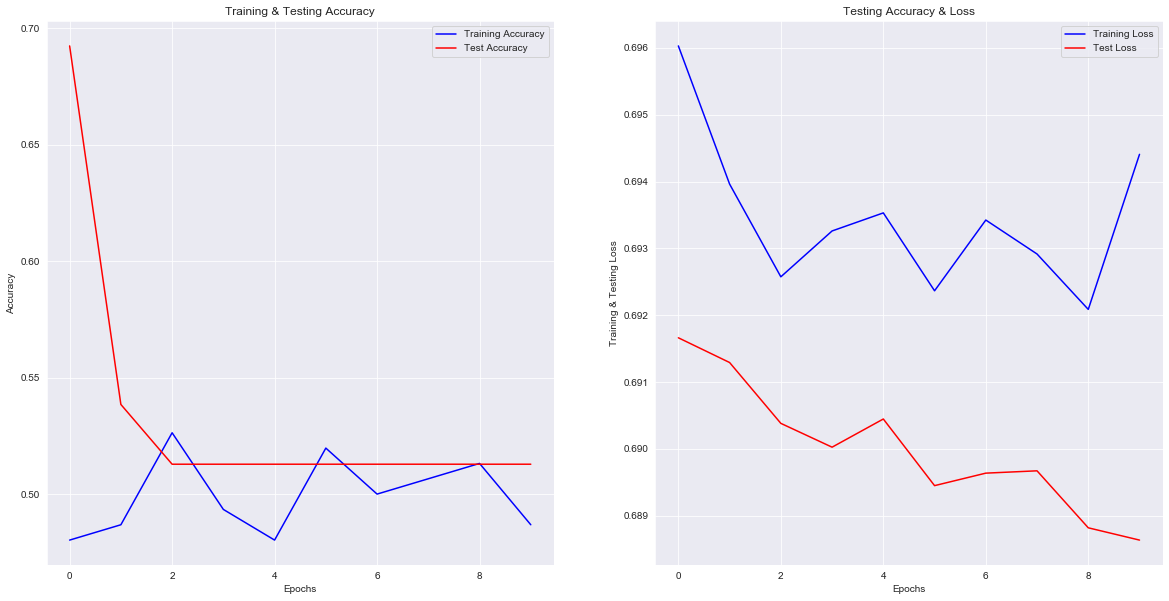

In [43]:
# Plot the accuracy and loss of model for each epoch
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)

# Return metrics from fit
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# Plot accuracy values per epoch
ax[0].plot(epochs , train_acc , 'b' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Test Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot loss values per epoch
ax[1].plot(epochs , train_loss , 'b' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Test Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Testing Loss")
plt.show()

It would appear that our model had found a local minima when conducting sgd and remained at the same accuracy throughout the entire period of training. We can see that training error was becoming lower for every epoch. This suggests to us that 10 epochs could be too few for our model to understand the important patterns within the data.

We will attempt another CNN, this time with regularization, another convolutional layer, and an increased amount of epochs in order to improve these results.

## CNN with Regularization

In [44]:
# Create regularized model with dropout
reg_model = models.Sequential()

# Add the appropriate layers
reg_model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(224, 224, 3)))
reg_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
reg_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
reg_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

reg_model.add(layers.Flatten())
reg_model.add(layers.Dense(512, activation='relu'))
reg_model.add(layers.Dropout(0.3))
reg_model.add(layers.Dense(512, activation='relu'))
reg_model.add(layers.Dropout(0.3))
reg_model.add(layers.Dense(2, activation='sigmoid'))

# Compile the model
reg_model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

# Augment the images
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

Again after assembling our model we will generate a summary and graph the shape of the model with `.summary()` and `.plot_model()`.

In [45]:
# Return summary of model
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

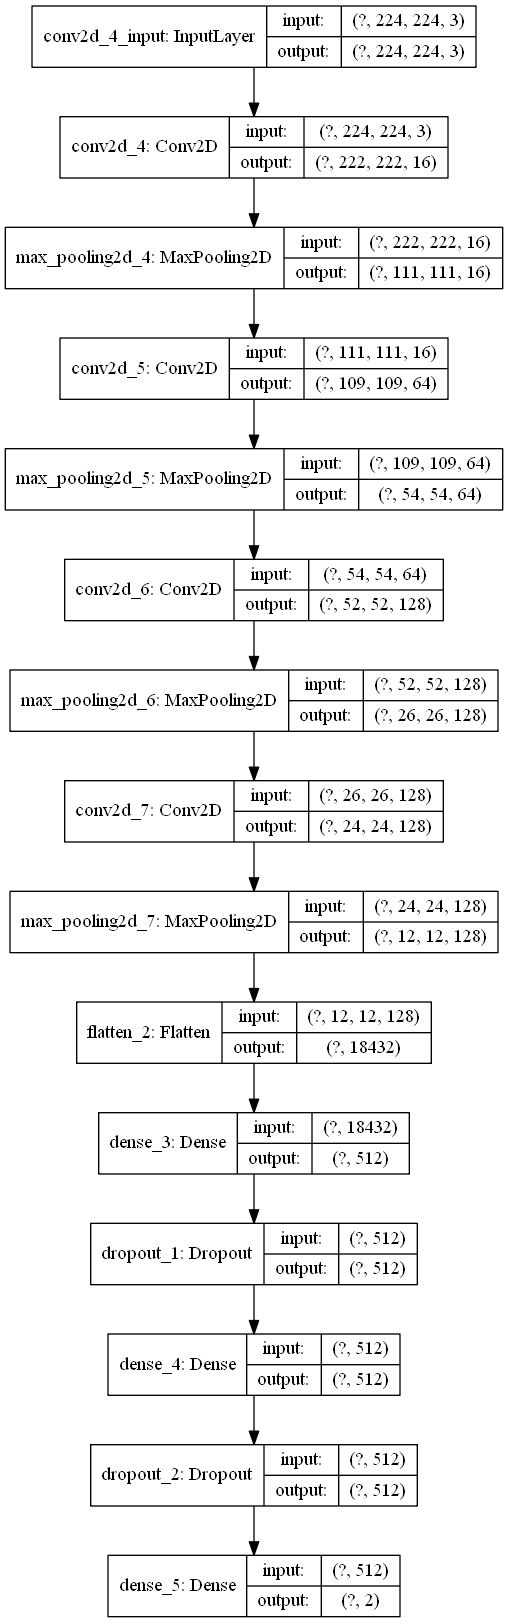

In [46]:
# Return image of model's architecture
plot_model(reg_model, show_shapes=True, show_layer_names=True)

In [47]:
# Fit our model, and define the number of epochs and steps per epoch
history = reg_model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    verbose=2,
                    epochs=10)

Epoch 1/10
 - 2s - loss: 0.8914 - accuracy: 0.5592 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/10
 - 2s - loss: 0.6961 - accuracy: 0.5164 - val_loss: 0.6928 - val_accuracy: 0.5128
Epoch 3/10
 - 2s - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5128
Epoch 4/10
 - 2s - loss: 0.6959 - accuracy: 0.4638 - val_loss: 0.6926 - val_accuracy: 0.6026
Epoch 5/10
 - 2s - loss: 0.6956 - accuracy: 0.5263 - val_loss: 0.6920 - val_accuracy: 0.5128
Epoch 6/10
 - 2s - loss: 0.6915 - accuracy: 0.5263 - val_loss: 0.6930 - val_accuracy: 0.4872
Epoch 7/10
 - 2s - loss: 0.6988 - accuracy: 0.4605 - val_loss: 0.6932 - val_accuracy: 0.4872
Epoch 8/10
 - 2s - loss: 0.6933 - accuracy: 0.4770 - val_loss: 0.6926 - val_accuracy: 0.5128
Epoch 9/10
 - 2s - loss: 0.6934 - accuracy: 0.5099 - val_loss: 0.6908 - val_accuracy: 0.5128
Epoch 10/10
 - 2s - loss: 0.7051 - accuracy: 0.5296 - val_loss: 0.6927 - val_accuracy: 0.5128


In [48]:
# Create predictions for the model
y_pred = reg_model.predict(X_test, batch_size=32)
y_pred_covid = reg_model.predict(covid_x_test, batch_size=32)

In [49]:
# Encode the labels of our test data
y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

In [50]:
# Generate a confusion matrix displaying the performance of the model
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
cm

array([[ 0, 19],
       [ 0, 20]], dtype=int64)

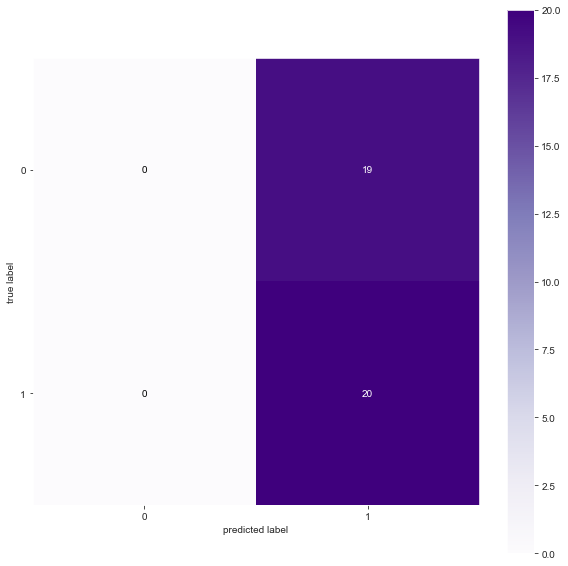

In [51]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm , figsize=(10, 10), cmap='Purples', colorbar=True)
plt.show()

In [52]:
# Generate classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.51      1.00      0.68        20

    accuracy                           0.51        39
   macro avg       0.26      0.50      0.34        39
weighted avg       0.26      0.51      0.35        39



C:\Users\morga\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


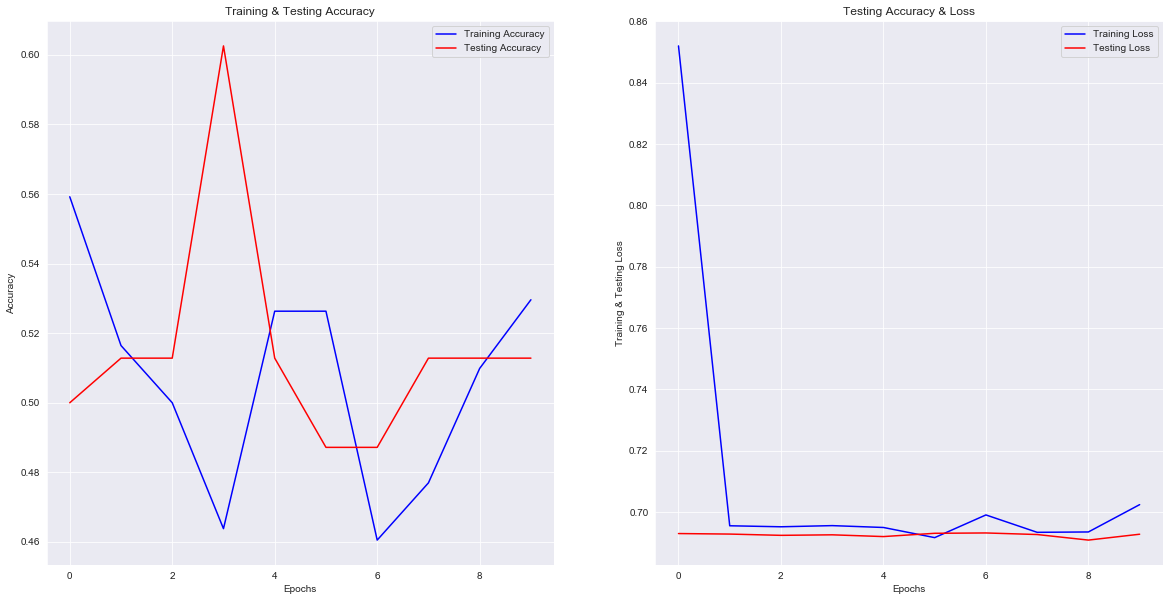

In [53]:
# Plot the accuracy and loss of model for each epoch
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)

# Return metrics from fit
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# Plot accuracy values per epoch
ax[0].plot(epochs , train_acc , 'b' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot loss values per epoch
ax[1].plot(epochs , train_loss , 'b' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Testing Loss")
plt.show()

The changes in our CNN's architecture and parameters has improved the performance of the model, but slightly. 

Until now however our model's have been rather opaque, we do not know what features our model is using in the training process. We will take a deeper look into how our network perceives the data by visualizing the intermediate hidden layers.

In [54]:
# Create a path to the first image in the positive group
img_path = 'dataset/covid_adjusted/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg.jpg'

In [55]:
from keras.preprocessing import image
# Assign the first image to a keras image object
img = image.load_img(img_path, target_size=(224, 224))
# Create a tensor of the images pixel values
img_tensor = image.img_to_array(img)
# Alter the dimentionality of the array to that of a tensor
img_tensor = np.expand_dims(img_tensor, axis=0)

In [56]:
#Follow the Original Model Preprocessing
img_tensor /= 255.

In [57]:
#Check tensor shape
print(img_tensor.shape)

(1, 224, 224, 3)


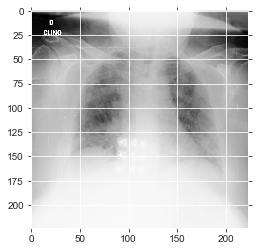

In [58]:
# Preview the first image
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([1],[1])
# ax.tick_params(axis=u'both', which=u'both',length=0)
ax.imshow(img_tensor[0])
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
plt.show()


Now that we have the image tensor displayed, we will visualize the feature maps that are generated during training. These feature maps will display the features that are present in the data. We would like to view how the convolutional layers transform the input images as it runs through the model. To this end, we will 

In [59]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in reg_model.layers[:8]]

In [60]:
from keras import models
# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=reg_model.input, outputs=layer_outputs)

In [61]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

In [62]:
# Create the first activation layer object
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 222, 222, 16)


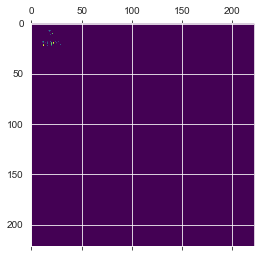

In [63]:
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

(1, 222, 222, 16)


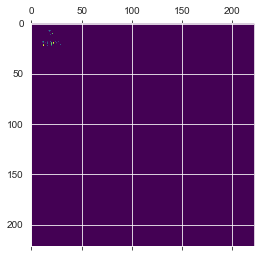

In [64]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

# Create the first activation layer object
first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

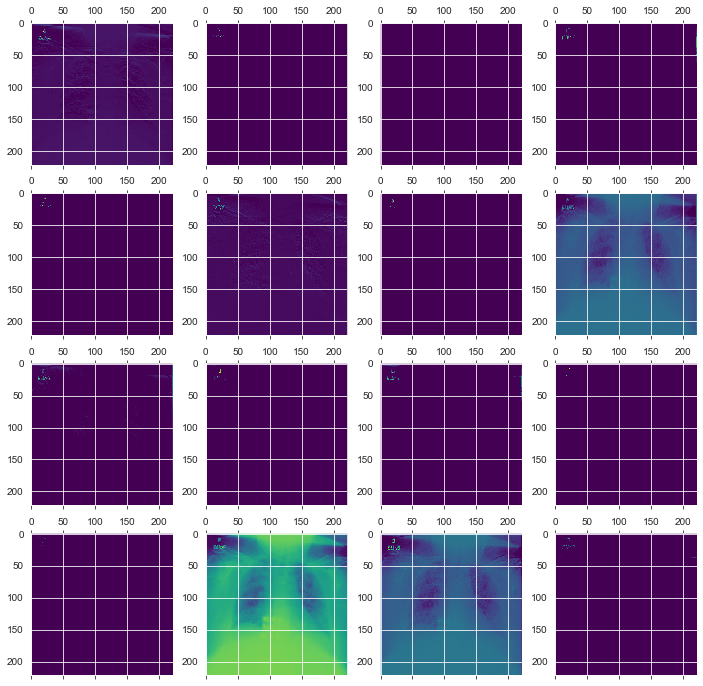

In [65]:
# Visualize all 16 of the channels from the first activation function
fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i in range(16):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')


We would like to vizualize the other layers of the model as well. Here we will visualize the 3rd channel for each of the activation layers.

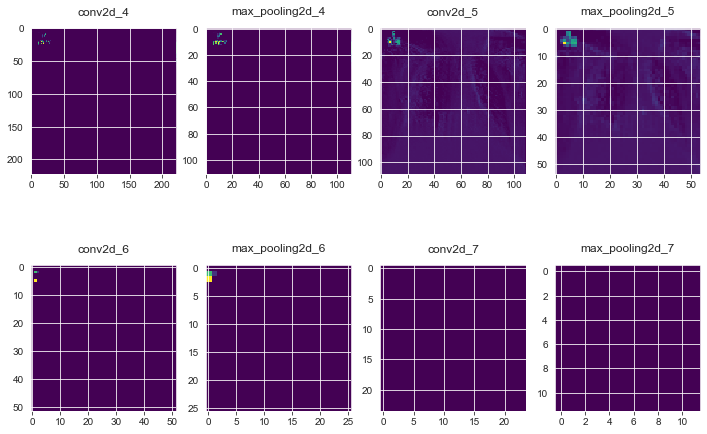

In [66]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in reg_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 3], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

It would appear that the model is picking up on the labeling of the image in the top left corner. In the display of the positive and negative images, it would appear that mode of the positive images have a similar label than the negative images. This may be an irrelevant pattern that the model has picked up on to distinguish the positive and negative cases. To get a more in-depth look, we can visualize each of the channels for each feature map in the convolutional layers.

To do this we will extract the feature maps, generate models that transform the image from its original shape to the feature maps. Finally we will take these transformations and visualize each channel for each feature map.

C:\Users\morga\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


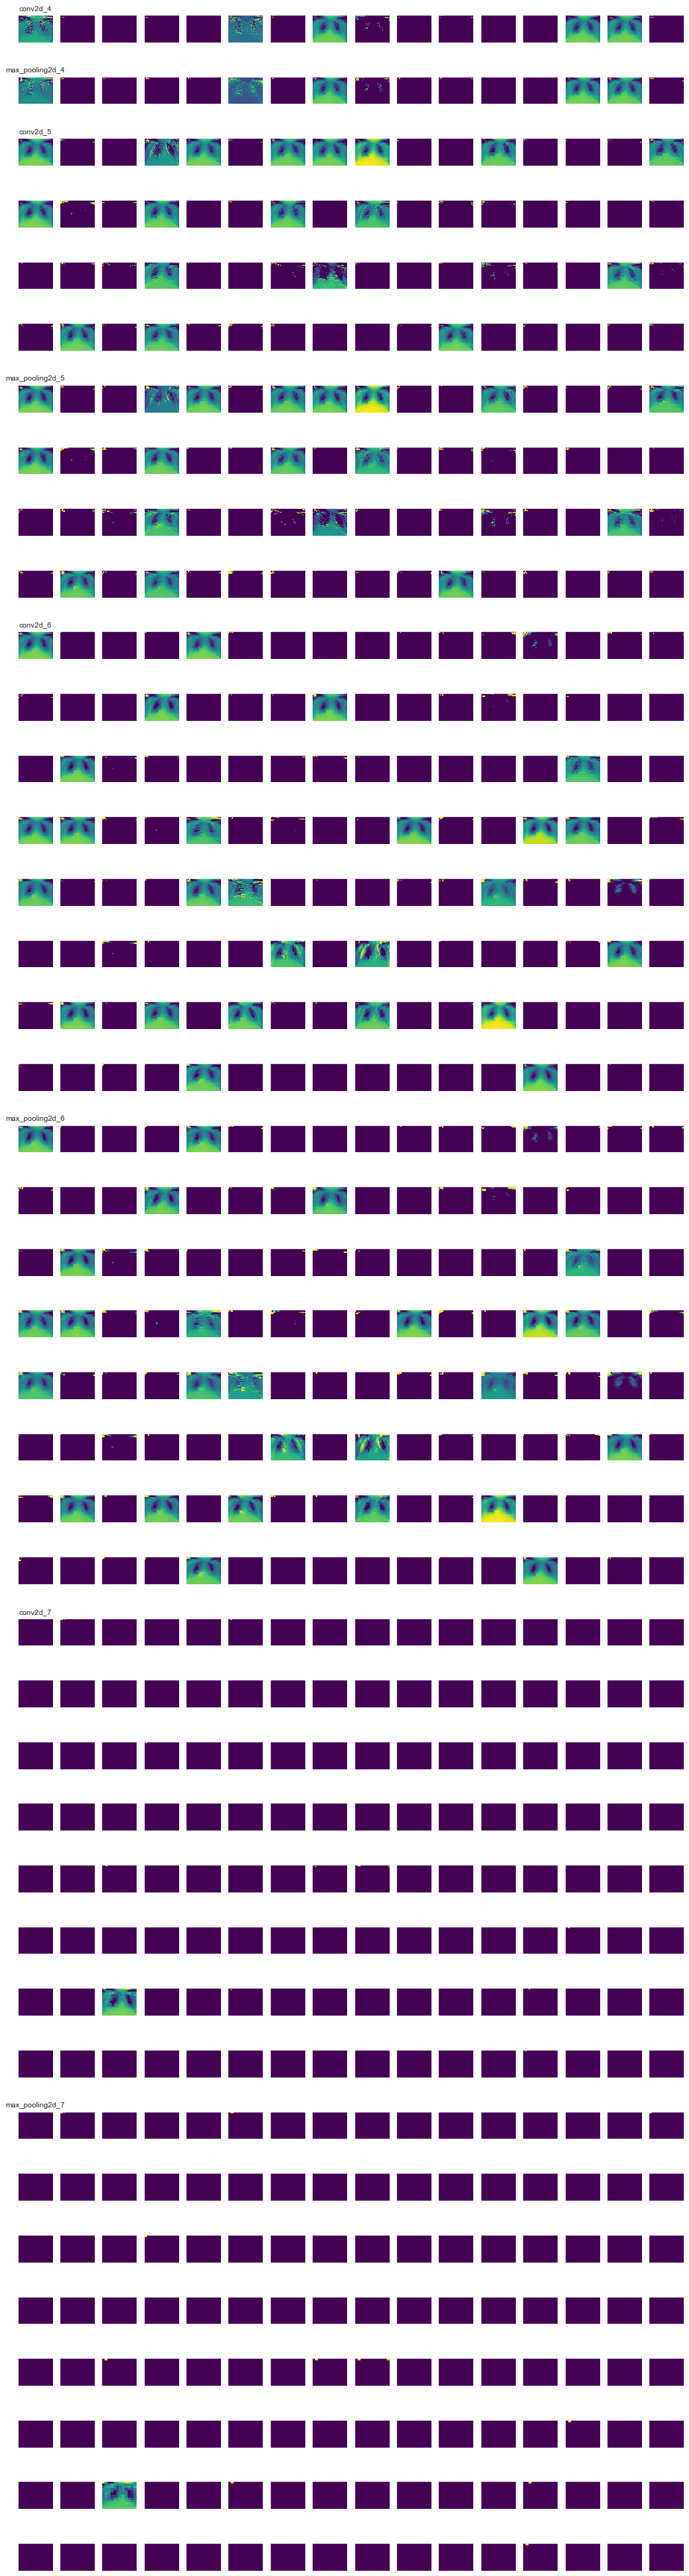

In [67]:
# Extract Layer Names for Labelling
layer_names = []
for layer in reg_model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

We can see that there are several feature maps which appear to observe patterns within the lungs of the person. There are also several images which are focused on the labels outside of the body of the person. We can see from these mappings that we could improve the performance of our model with more preprocessing of the data, removing these labels from images so that there is as little deviation from the actual format of the photos as possible. 

After these visualizations, we will turn to transfer learning to make use of much more powerful CNN's to improve performance, namely we will use VGG19 and Inception v3.

## Transfer Learning with VGG19

We will now utilize transfer learning to improve our performance. We will use the VGG19 model which is a 19 layer convolutional neural network created by the Oxford Visual Geometry Group for the ImageNet Large Scale Visual Recognition Challenge ILSVRC-2014 competition trained on 4 GPUs for 2–3 weeks. 

Transfer learning as defined by Goodfellow et al in *Deep Learning* is "Situation where what has been learned in one setting is exploited to improve generalization in another setting". By this definition, we will use the weights gained from the large imagenet dataset, and the architecture of VGG19 to generalize for our covid-19 dataset. This should improve our predicting performance to reach the metrics of our success threshold.

We will begin by creating an instance of VGG19 with weights already created from the imagenet training. We will then add new layers at the end of the model so that it can properly predict for our dataset.

In [68]:
# Create vgg19 model
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Add layers to model
outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

# Set the correct inputs and outputs to the model
vgg_model = Model(inputs=vggModel.input, outputs=outputs)

# Set the layers to frozen to keep the weights already made
for layer in vggModel.layers:
    layer.trainable = False

# Compile the model
vgg_model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

# Augment the data
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [69]:
# Return summary of model
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

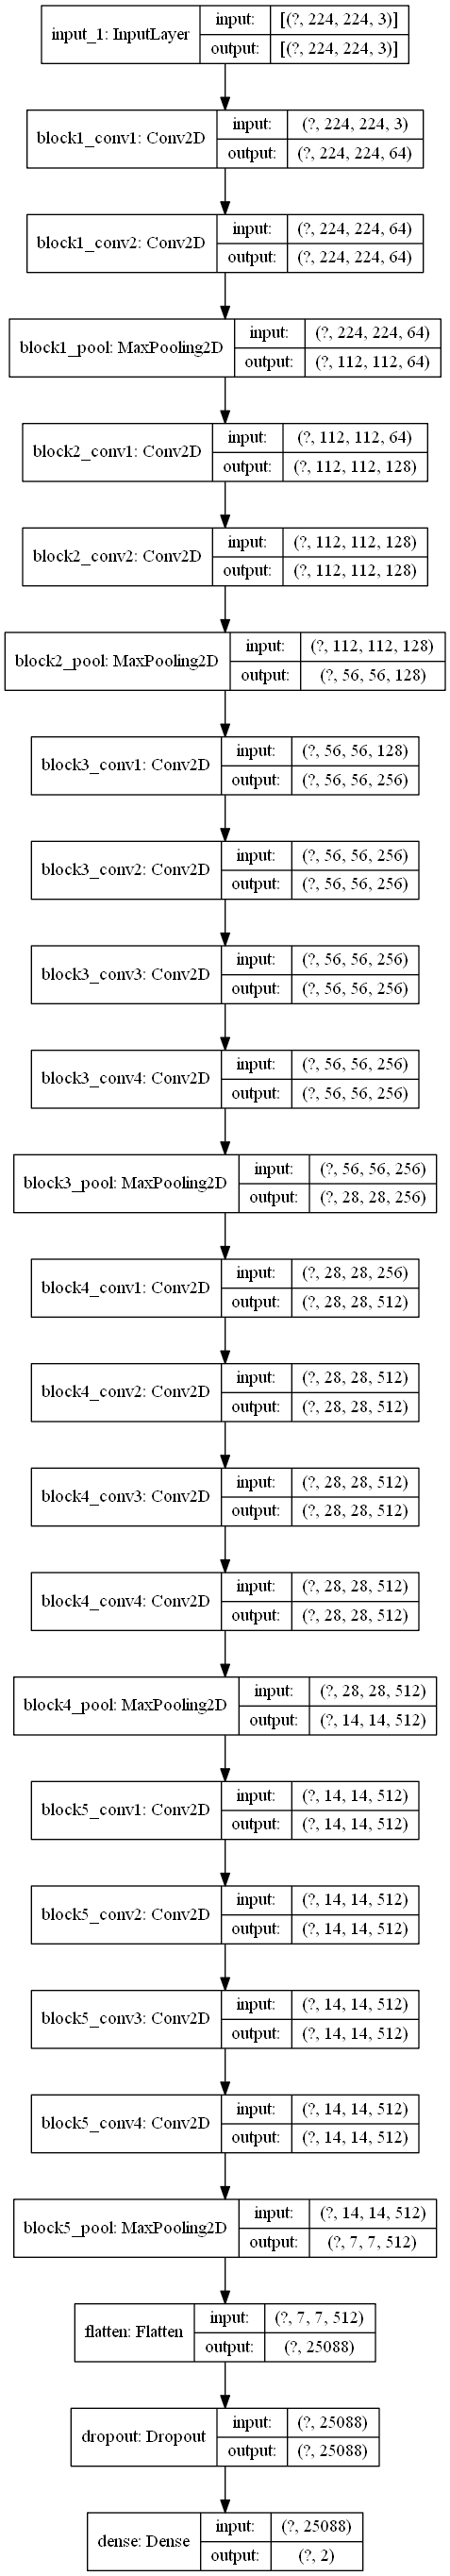

In [70]:
# Plot model architecture
plot_model(vgg_model, show_shapes=True, show_layer_names=True)

In [71]:
# Import callbacks to adjust and save models while training
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [72]:
# Create ModelCheckpoint for callbacks
# autosave best Model
best_model_file = "vgg.h5"
best_model = ModelCheckpoint(
    best_model_file, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=4,
    min_lr=10e-7)

C:\Users\morga\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [73]:
# Fit our model, and define the number of epochs and steps per epoch
history = vgg_model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=50,
                    verbose=2,
                    callbacks=[best_model, rlrop]
                    )

Epoch 1/50
Epoch 1/50
39/4 - 2s - loss: 0.7855 - acc: 0.4872

Epoch 00001: val_acc improved from -inf to 0.48718, saving model to vgg.h5
5/4 - 8s - loss: 1.6280 - acc: 0.5329 - val_loss: 1.5486 - val_acc: 0.4872
Epoch 2/50
Epoch 1/50
39/4 - 1s - loss: 2.4833 - acc: 0.5128

Epoch 00002: val_acc improved from 0.48718 to 0.51282, saving model to vgg.h5
5/4 - 3s - loss: 1.5279 - acc: 0.4737 - val_loss: 2.0336 - val_acc: 0.5128
Epoch 3/50
Epoch 1/50
39/4 - 0s - loss: 0.3883 - acc: 0.5385

Epoch 00003: val_acc improved from 0.51282 to 0.53846, saving model to vgg.h5
5/4 - 2s - loss: 1.1252 - acc: 0.5329 - val_loss: 0.5017 - val_acc: 0.5385
Epoch 4/50
Epoch 1/50
39/4 - 0s - loss: 1.3784 - acc: 0.6667

Epoch 00004: val_acc improved from 0.53846 to 0.66667, saving model to vgg.h5
5/4 - 3s - loss: 1.0730 - acc: 0.5395 - val_loss: 1.1230 - val_acc: 0.6667
Epoch 5/50
Epoch 1/50
39/4 - 0s - loss: 0.4684 - acc: 0.7949

Epoch 00005: val_acc improved from 0.66667 to 0.79487, saving model to vgg.h5
5/4

Epoch 44/50
Epoch 1/50
39/4 - 0s - loss: 0.4948 - acc: 0.8462

Epoch 00044: val_acc did not improve from 0.84615

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5/4 - 2s - loss: 0.3345 - acc: 0.8355 - val_loss: 0.4196 - val_acc: 0.8462
Epoch 45/50
Epoch 1/50
39/4 - 0s - loss: 0.6529 - acc: 0.8462

Epoch 00045: val_acc did not improve from 0.84615
5/4 - 2s - loss: 0.3077 - acc: 0.8487 - val_loss: 0.5356 - val_acc: 0.8462
Epoch 46/50
Epoch 1/50
39/4 - 0s - loss: 0.5542 - acc: 0.8718

Epoch 00046: val_acc improved from 0.84615 to 0.87179, saving model to vgg.h5
5/4 - 2s - loss: 0.3080 - acc: 0.8882 - val_loss: 0.4703 - val_acc: 0.8718
Epoch 47/50
Epoch 1/50
39/4 - 0s - loss: 0.5810 - acc: 0.8462

Epoch 00047: val_acc did not improve from 0.87179
5/4 - 2s - loss: 0.3863 - acc: 0.8224 - val_loss: 0.4873 - val_acc: 0.8462
Epoch 48/50
Epoch 1/50
39/4 - 0s - loss: 0.6471 - acc: 0.8462

Epoch 00048: val_acc did not improve from 0.87179
5/4 - 3s - loss: 0.3728 -

In [74]:
# Create predictions for the model
y_pred = vgg_model.predict(X_test, batch_size=32)
y_pred_covid = vgg_model.predict(covid_x_test, batch_size=32)

In [75]:
# Encode the labels of our test data
y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

In [76]:
# Generate a confusion matrix displaying the performance of the model
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
cm

array([[15,  4],
       [ 3, 17]], dtype=int64)

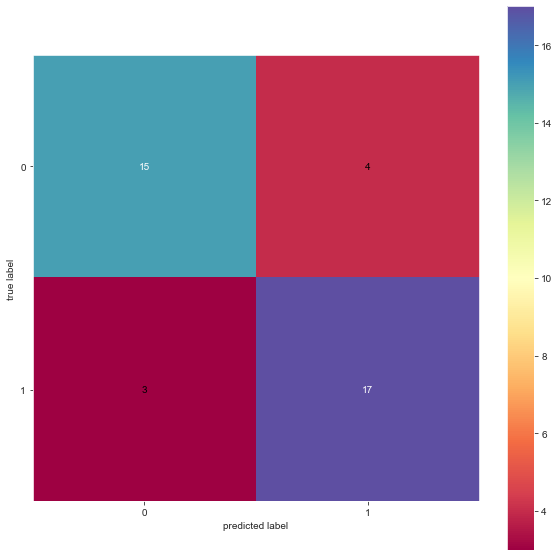

In [77]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, cmap='Spectral', colorbar=True, figsize=(10, 10))
plt.show()

In [78]:
# Generate classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        19
           1       0.81      0.85      0.83        20

    accuracy                           0.82        39
   macro avg       0.82      0.82      0.82        39
weighted avg       0.82      0.82      0.82        39



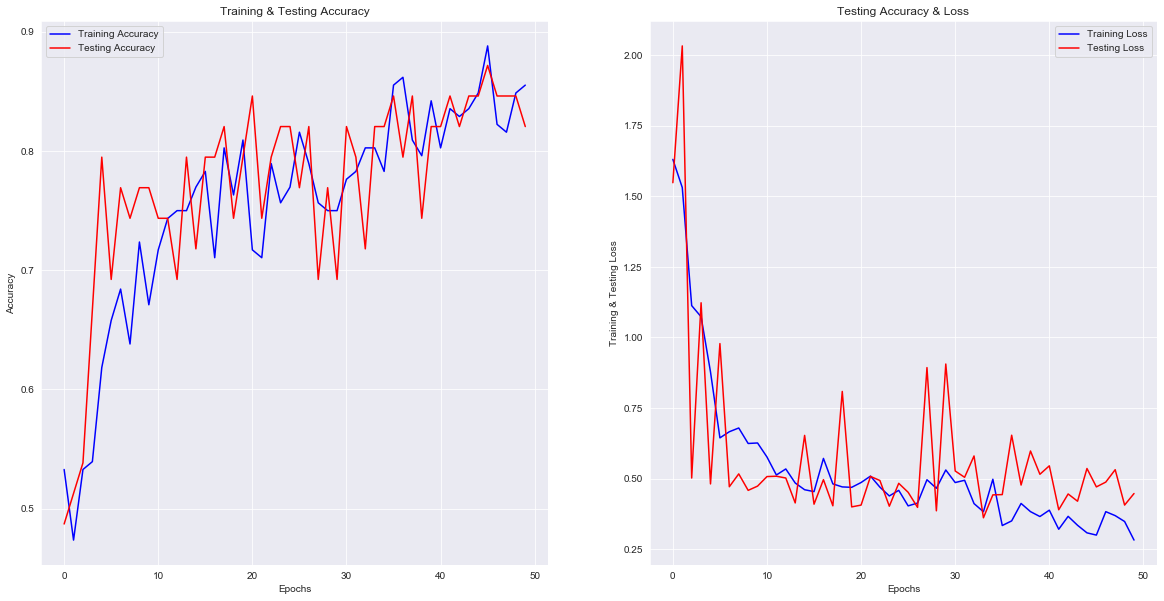

In [79]:
# Plot the accuracy and loss of model for each epoch
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)

# Return metrics from fit
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# Plot accuracy values per epoch
ax[0].plot(epochs , train_acc , 'b' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot loss values per epoch
ax[1].plot(epochs , train_loss , 'b' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Testing Loss")
plt.show()

Let's take a look at the actual images that our model was able to correctly and incorrectly predict. We can simply create lists that contain the correct predictions and incorrect predictions, then iterate through these lists and plot a sampling of the images from each list.

In [80]:
# Create lists of correct & incorrect predictions
correct = np.nonzero(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))[0]
incorrect = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

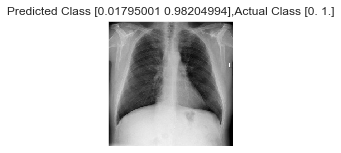

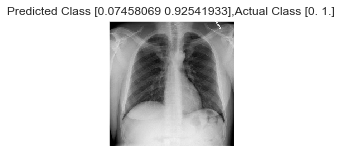

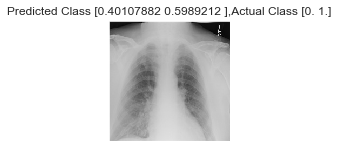

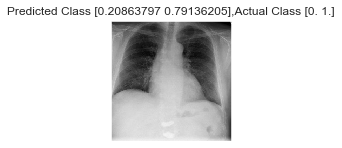

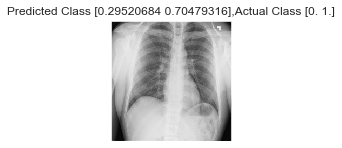

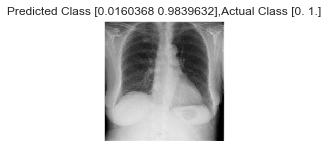

In [81]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
i = 0
for c in correct[:6]:
    figsize = [10, 6]
    fig, ax = plt.subplots(figsize=figsize, facecolor=(1, 1, 1))
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c], interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

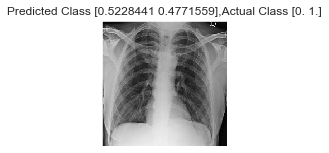

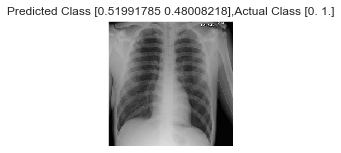

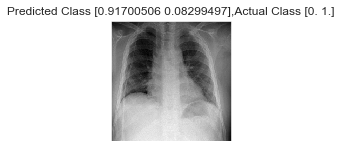

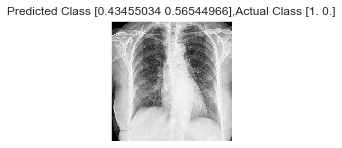

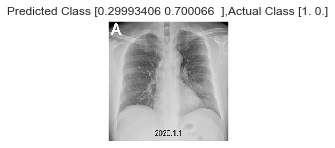

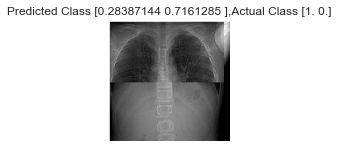

In [82]:
# Use a for loop to iterate through incorrect predictions,
# display the prediction values for each image and the actual class of the model
i = 0
for c in incorrect[:6]:
    figsize = [10, 6]
    fig, ax = plt.subplots(figsize=figsize, facecolor=(1, 1, 1))
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c], interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Inception v3

The last model we will use is Google's Inception v3. It was also introduced during the ImageNet Recognition Challenge and thus was trained using the original ImageNet dataset which was trained with over 1 million training images. This installment of Inception has 48 layers, and is thus much larger than VGG19 although it has only ~1 million more parameters. We will conduct transfer learning with Inception v3 to determine if our predictive performance improves with this more complex model.

In [83]:
# Import keras modules
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D

In [84]:
# Create the base pre-trained model
inc_Model = InceptionV3(weights='imagenet', include_top=False , input_shape=(224, 224, 3))

In [85]:
# Add layers to model
outputs = inc_Model.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

# Set the correct inputs and outputs to the model
inc_model = Model(inputs=inc_Model.input, outputs=outputs)

# Set the layers to frozen to keep the weights already made
for layer in inc_Model.layers:
    layer.trainable = False

# Compile the model
inc_model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

# Augment the data
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [86]:
# Return summary of model
inc_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [87]:
# Plot model architecture
plot_model(inc_model, show_shapes=True, show_layer_names=True)

In [88]:
# Fit our model, and define the number of epochs and steps per epoch
history = inc_model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10,
                    verbose=2,
                    callbacks=[best_model, rlrop]
                    )

Epoch 1/10
 - 10s - loss: 5.5255 - accuracy: 0.5395 - val_loss: 16.8262 - val_accuracy: 0.5128


C:\Users\morga\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/10
 - 2s - loss: 5.5207 - accuracy: 0.5263 - val_loss: 9.9434 - val_accuracy: 0.4872
Epoch 3/10
 - 1s - loss: 3.5663 - accuracy: 0.5987 - val_loss: 8.0385 - val_accuracy: 0.5128
Epoch 4/10
 - 2s - loss: 2.8163 - accuracy: 0.6184 - val_loss: 1.9284 - val_accuracy: 0.5385
Epoch 5/10
 - 2s - loss: 1.6957 - accuracy: 0.6382 - val_loss: 4.8028 - val_accuracy: 0.5128
Epoch 6/10
 - 2s - loss: 1.3564 - accuracy: 0.7434 - val_loss: 1.9098 - val_accuracy: 0.6410
Epoch 7/10
 - 2s - loss: 0.8488 - accuracy: 0.7434 - val_loss: 2.5247 - val_accuracy: 0.5897
Epoch 8/10
 - 2s - loss: 0.8494 - accuracy: 0.7895 - val_loss: 1.8512 - val_accuracy: 0.5897
Epoch 9/10
 - 2s - loss: 0.6141 - accuracy: 0.7632 - val_loss: 2.5085 - val_accuracy: 0.6154
Epoch 10/10
 - 2s - loss: 0.6030 - accuracy: 0.8487 - val_loss: 2.2677 - val_accuracy: 0.5897


In [89]:
# Create predictions for the model
y_pred = inc_model.predict(X_test, batch_size=32)
y_pred_covid = inc_model.predict(covid_x_test, batch_size=32)

In [90]:
# Encode the labels of our test data
y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

In [91]:
# Generate a confusion matrix displaying the performance of the model
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
cm

array([[ 8, 11],
       [ 5, 15]], dtype=int64)

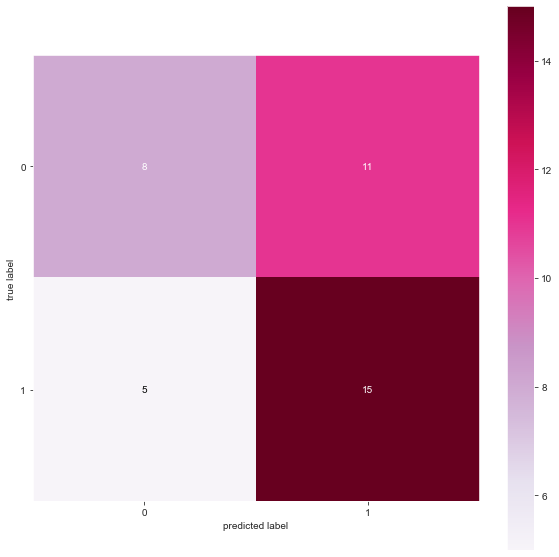

In [92]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, cmap='PuRd', colorbar=True, figsize=(10, 10))
plt.show()

In [93]:
# Generate classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        19
           1       0.58      0.75      0.65        20

    accuracy                           0.59        39
   macro avg       0.60      0.59      0.58        39
weighted avg       0.60      0.59      0.58        39



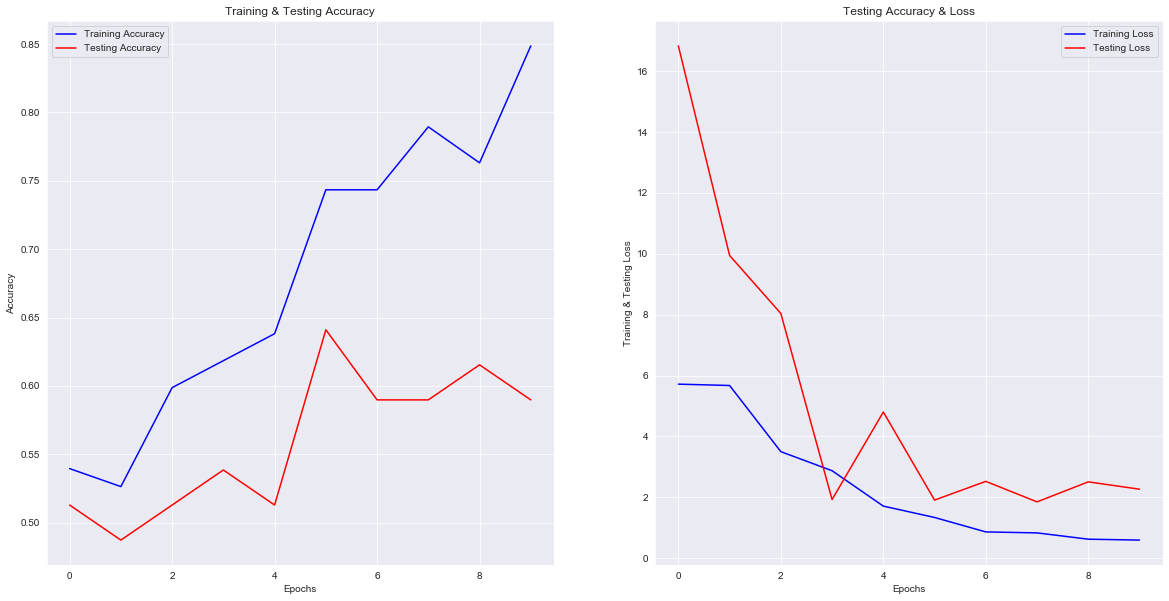

In [94]:
# Plot the accuracy and loss of model for each epoch
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)

# Return metrics from fit
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# Plot accuracy values per epoch
ax[0].plot(epochs , train_acc , 'b' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot loss values per epoch
ax[1].plot(epochs , train_loss , 'b' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Testing Loss")
plt.show()

In [95]:
pne_train_dir = 'Misc/pneumonia_dataset/chest_xray/train/PNEUMONIA'
norm_train_dir = 'Misc/pneumonia_dataset/chest_xray/train/NORMAL'

pne_test_dir = 'Misc/pneumonia_dataset/chest_xray/test/PNEUMONIA'
norm_test_dir = 'Misc/pneumonia_dataset/chest_xray/test/NORMAL'

pne_val_dir = 'Misc/pneumonia_dataset/chest_xray/val/PNEUMONIA'
norm_val_dir = 'Misc/pneumonia_dataset/chest_xray/val/NORMAL'

In [96]:
imgs_pne_train = [file for file in os.listdir(pne_train_dir) if file.endswith('.jpeg')]

In [97]:
type(imgs_pne_train)

list

In [98]:
imgs_pne_train[0:5]

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg']

In [99]:
print('There are', len(imgs_pne_train), 'Pneumonia training images')

There are 3778 Pneumonia training images


In [100]:
imgs_norm_train = [file for file in os.listdir(norm_train_dir) if file.endswith('.jpeg')]

In [101]:
print('There are', len(imgs_norm_train), 'Normal training images')

There are 1244 Normal training images


In [102]:
imgs_pne_test = [file for file in os.listdir(
    pne_test_dir) if file.endswith('.jpeg')]
imgs_norm_test = [file for file in os.listdir(
    norm_test_dir) if file.endswith('.jpeg')]

imgs_pne_val = [file for file in os.listdir(
    pne_val_dir) if file.endswith('.jpeg')]
imgs_norm_val = [file for file in os.listdir(
    norm_val_dir) if file.endswith('.jpeg')]

print('There are', len(imgs_pne_train), 'Pneumonia training images')
print('There are', len(imgs_norm_train), 'Normal training images')
print('\n')
print('There are', len(imgs_pne_test), 'Pneumonia testing images')
print('There are', len(imgs_norm_test), 'Normal testing images')
print('\n')
print('There are', len(imgs_pne_val), 'Pneumonia validation images')
print('There are', len(imgs_norm_val), 'Normal validation images')
print('\n')
print('There are', len(imgs_pne_train)+len(imgs_norm_train)+len(imgs_pne_test) +
      len(imgs_norm_test)+len(imgs_pne_val)+len(imgs_norm_val), 'images in total.')

There are 3778 Pneumonia training images
There are 1244 Normal training images


There are 390 Pneumonia testing images
There are 234 Normal testing images


There are 105 Pneumonia validation images
There are 105 Normal validation images


There are 5856 images in total.


Let's take a look at our first image in the pneumonia training set:

In [103]:
from keras.preprocessing.image import image, array_to_img, img_to_array, load_img, ImageDataGenerator
from keras import optimizers
np.random.seed(123)

(1, 224, 224, 3)


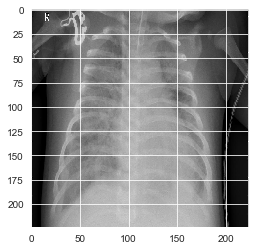

In [104]:
img_path = 'Misc/pneumonia_dataset/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [105]:
# get all the data in the directory test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'Misc/pneumonia_dataset/chest_xray/test', 
        target_size=(224, 224), batch_size = 624) 

# get all the data in the directory validation (210 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'Misc/pneumonia_dataset/chest_xray/val', 
        target_size=(224, 224), batch_size = 210)

# get all the data in the directory split/train (5022 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'Misc/pneumonia_dataset/chest_xray/train', 
        target_size=(224, 224), batch_size=5022)

Found 624 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 5022 images belonging to 2 classes.


In [106]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [107]:
# plot images with labels
def plots(ims, figsize=(12,12), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

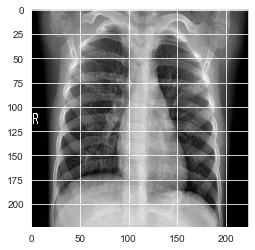

In [108]:
plt.imshow(train_images[0])

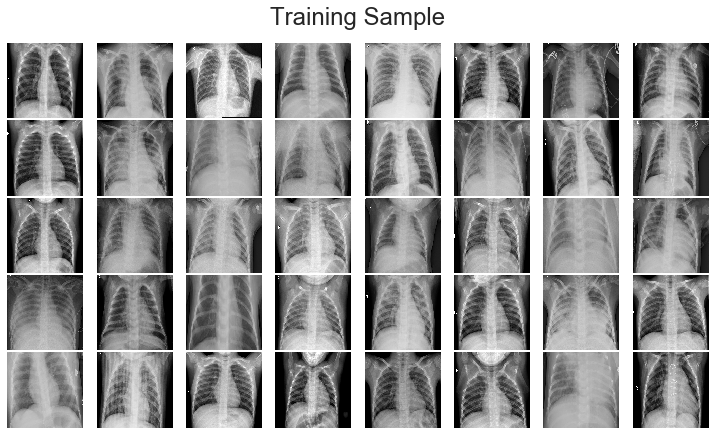

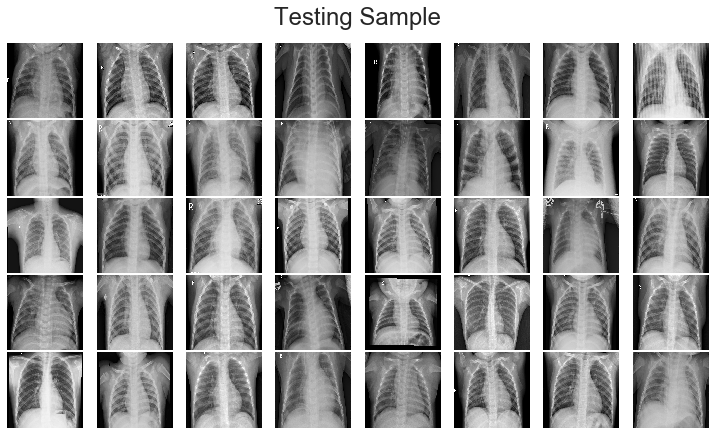

In [109]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

plot_images(train_images, 'Training Sample')
plot_images(test_images, 'Testing Sample')

In [110]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5022
Number of testing samples: 624
Number of validation samples: 210
train_images shape: (5022, 224, 224, 3)
train_labels shape: (5022, 2)
test_images shape: (624, 224, 224, 3)
test_labels shape: (624, 2)
val_images shape: (210, 224, 224, 3)
val_labels shape: (210, 2)


In [111]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5022, 150528)
(624, 150528)
(210, 150528)


In [112]:
train_y = np.reshape(train_labels[:,0], (5022,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (210,1))

In [113]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D

Artificial Neural Network

In [114]:
# Build a baseline fully connected model
from keras import models
from keras import layers

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(150528,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [115]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                3010580   
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 3,010,773
Trainable params: 3,010,773
Non-trainable params: 0
_________________________________________________________________


In [116]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    callbacks=[best_model, rlrop]
                    )

Train on 5022 samples, validate on 210 samples
Epoch 1/10
5022/5022 [==============================] - 5s 897us/step - loss: 0.5053 - accuracy: 0.7830 - val_loss: 0.6257 - val_accuracy: 0.7571
Epoch 2/10
5022/5022 [==============================] - 4s 771us/step - loss: 0.3560 - accuracy: 0.8521 - val_loss: 0.4801 - val_accuracy: 0.9000
Epoch 3/10
5022/5022 [==============================] - 4s 809us/step - loss: 0.2887 - accuracy: 0.8941 - val_loss: 0.5129 - val_accuracy: 0.8286
Epoch 4/10
5022/5022 [==============================] - 4s 795us/step - loss: 0.2620 - accuracy: 0.9114 - val_loss: 0.4861 - val_accuracy: 0.8476
Epoch 5/10
5022/5022 [==============================] - 4s 777us/step - loss: 0.2410 - accuracy: 0.9213 - val_loss: 0.4467 - val_accuracy: 0.8429
Epoch 6/10
5022/5022 [==============================] - 4s 781us/step - loss: 0.2240 - accuracy: 0.9249 - val_loss: 0.4961 - val_accuracy: 0.8095
Epoch 7/10
5022/5022 [==============================] - 4s 817us/step - loss:

In [117]:
results_train = model.evaluate(train_img, train_y) 

5022/5022 [==============================] - 4s 744us/step


In [118]:
results_test = model.evaluate(test_img, test_y)

624/624 [==============================] - 1s 1ms/step


In [119]:
results_train

[0.14527824025842972, 0.9605734944343567]

In [120]:
results_test

[0.7331751309908353, 0.7628205418586731]

Baseline CNN:

In [121]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [122]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43264)            

In [123]:
history = model.fit(train_images,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks=[best_model, rlrop]
                    )

Train on 5022 samples, validate on 210 samples
Epoch 1/10
5022/5022 [==============================] - 14s 3ms/step - loss: 0.4867 - acc: 0.7720 - val_loss: 0.4671 - val_acc: 0.8000

Epoch 00001: val_acc did not improve from 0.87179
Epoch 2/10
5022/5022 [==============================] - 13s 2ms/step - loss: 0.3021 - acc: 0.8833 - val_loss: 0.3035 - val_acc: 0.9238

Epoch 00002: val_acc improved from 0.87179 to 0.92381, saving model to vgg.h5
Epoch 3/10
5022/5022 [==============================] - 12s 2ms/step - loss: 0.1910 - acc: 0.9239 - val_loss: 0.5418 - val_acc: 0.7762

Epoch 00003: val_acc did not improve from 0.92381
Epoch 4/10
5022/5022 [==============================] - 12s 2ms/step - loss: 0.1423 - acc: 0.9458 - val_loss: 0.2462 - val_acc: 0.8857

Epoch 00004: val_acc did not improve from 0.92381
Epoch 5/10
5022/5022 [==============================] - 12s 2ms/step - loss: 0.1365 - acc: 0.9450 - val_loss: 0.3683 - val_acc: 0.8429

Epoch 00005: val_acc did not improve from 0.9

In [124]:
results_train = model.evaluate(train_images, train_y)

5022/5022 [==============================] - 6s 1ms/step


In [125]:
results_test = model.evaluate(test_images, test_y)

624/624 [==============================] - 1s 1ms/step


In [126]:
results_train

[0.07990915979114437, 0.9719235301017761]

In [127]:
results_test

[0.8706132677885202, 0.7644230723381042]

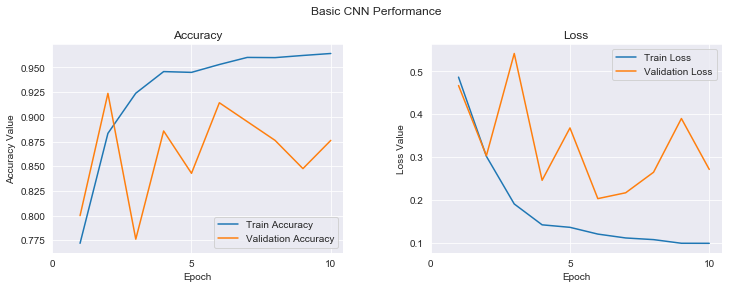

In [128]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

CNN with Regularization

In [129]:
input_shape = (224, 224, 3)

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [130]:
history = model.fit(train_images,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Train on 5022 samples, validate on 210 samples
Epoch 1/10
5022/5022 [==============================] - 17s 3ms/step - loss: 0.4873 - accuracy: 0.8437 - val_loss: 0.2854 - val_accuracy: 0.8857
Epoch 2/10
5022/5022 [==============================] - 14s 3ms/step - loss: 0.1872 - accuracy: 0.9387 - val_loss: 0.2359 - val_accuracy: 0.8857
Epoch 3/10
5022/5022 [==============================] - 14s 3ms/step - loss: 0.1199 - accuracy: 0.9590 - val_loss: 0.1139 - val_accuracy: 0.9429
Epoch 4/10
5022/5022 [==============================] - 14s 3ms/step - loss: 0.0975 - accuracy: 0.9661 - val_loss: 0.0952 - val_accuracy: 0.9571
Epoch 5/10
5022/5022 [==============================] - 14s 3ms/step - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.1629 - val_accuracy: 0.9333
Epoch 6/10
5022/5022 [==============================] - 14s 3ms/step - loss: 0.0720 - accuracy: 0.9787 - val_loss: 0.1707 - val_accuracy: 0.9476
Epoch 7/10
5022/5022 [==============================] - 15s 3ms/step - loss: 0.0704

In [131]:
results_train = model.evaluate(train_images, train_y)

5022/5022 [==============================] - 6s 1ms/step


In [132]:
results_test = model.evaluate(test_images, test_y)

624/624 [==============================] - 1s 1ms/step


In [133]:
results_train

[0.12301167991451477, 0.9639585614204407]

In [134]:
results_test

[1.388348984412658, 0.8060897588729858]

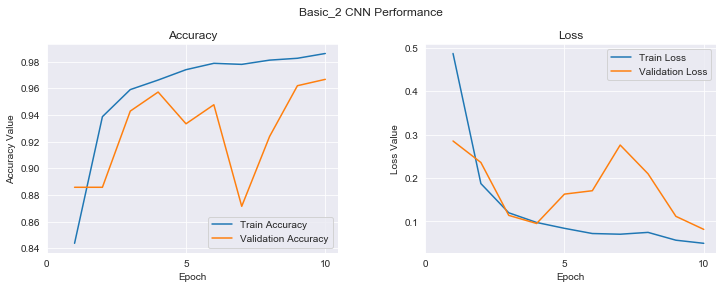

In [135]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic_2 CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [136]:
# model.save('basic_cnn.h5')

VGG16

In [137]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

Layer Type  \
0   <keras.engine.input_layer.InputLayer object at 0x00000232EF837448>   
1   <keras.layers.convolutional.Conv2D object at 0x00000232EF8375C8>     
2   <keras.layers.convolutional.Conv2D object at 0x00000232EF837708>     
3   <keras.layers.pooling.MaxPooling2D object at 0x00000232EF538648>     
4   <keras.layers.convolutional.Conv2D object at 0x00000232EF526648>     
5   <keras.layers.convolutional.Conv2D object at 0x00000232EF5455C8>     
6   <keras.layers.pooling.MaxPooling2D object at 0x00000232EF536708>     
7   <keras.layers.convolutional.Conv2D object at 0x00000232EF544148>     
8   <keras.layers.convolutional.Conv2D object at 0x00000232EF541A08>     
9   <keras.layers.convolutional.Conv2D object at 0x00000232EF52C688>     
10  <keras.layers.pooling.MaxPooling2D object at 0x00000232EF517E08>     
11  <keras.layers.convolutional.Conv2D object at 0x00000232EF3F4588>     
12  <keras.layers.convolutional.Conv2D object at 0x00000232EF514548>     
13  <keras.layers.convolutional.Conv2D object at 0x00000232EF40C288>     
14  <keras.layers.pooling.MaxPooling2D object at 0x00000232EF3FBE48>     
15  <keras.layers.convolutional.Conv2D object at 0x00000232EF3EB488>     
16  <keras.layers.convolutional.Conv2D object at 0x00000232EF3ED248>     
17  <keras.layers.convolutional.Conv2D object at 0x00000232EF3D0F88>     
18  <keras.layers.pooling.MaxPooling2D object at 0x00000232EF15DC08>     
19  <keras.layers.core.Flatten object at 0x00000232EF837588>             

      Layer Name  Layer Trainable  
0   input_3       False            
1   block1_conv1  False            
2   block1_conv2  False            
3   block1_pool   False            
4   block2_conv1  False            
5   block2_conv2  False            
6   block2_pool   False            
7   block3_conv1  False            
8   block3_conv2  False            
9   block3_conv3  False            
10  block3_pool   False            
11  block4_conv1  False            
12  block4_conv2  False            
13  block4_conv3  False            
14  block4_pool   False            
15  block5_conv1  False            
16  block5_conv2  False            
17  block5_conv3  False            
18  block5_pool   False            
19  flatten_5     False

(1, 7, 7, 512)


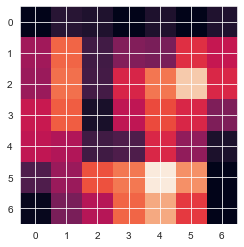

In [138]:
bottleneck_feature_example = vgg.predict(train_images[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [139]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_images)
validation_features_vgg = get_bottleneck_features(vgg_model, val_images)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (5022, 25088) 	Validation Bottleneck Features: (210, 25088)


In [140]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]
epochs = 100
batch_size = 32

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 13,108,737
Trainable params: 13,108,737
Non-trainable params: 0
_________________________________________________________________


In [141]:
history = model.fit(x=train_features_vgg, y=train_y,
                    validation_data=(validation_features_vgg, val_y),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[best_model, rlrop]
                    )

Train on 5022 samples, validate on 210 samples
Epoch 1/100
 - 4s - loss: 0.2040 - accuracy: 0.9136 - val_loss: 0.3687 - val_accuracy: 0.8857


C:\Users\morga\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/100
 - 3s - loss: 0.0886 - accuracy: 0.9681 - val_loss: 0.4605 - val_accuracy: 0.8857
Epoch 3/100
 - 3s - loss: 0.0727 - accuracy: 0.9711 - val_loss: 0.0900 - val_accuracy: 0.9714
Epoch 4/100
 - 3s - loss: 0.0621 - accuracy: 0.9775 - val_loss: 0.2290 - val_accuracy: 0.9095
Epoch 5/100
 - 3s - loss: 0.0516 - accuracy: 0.9819 - val_loss: 0.3902 - val_accuracy: 0.9000
Epoch 6/100
 - 3s - loss: 0.0482 - accuracy: 0.9849 - val_loss: 0.0491 - val_accuracy: 0.9810
Epoch 7/100
 - 3s - loss: 0.0406 - accuracy: 0.9855 - val_loss: 0.1780 - val_accuracy: 0.9619
Epoch 8/100
 - 3s - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.1173 - val_accuracy: 0.9619
Epoch 9/100
 - 3s - loss: 0.0334 - accuracy: 0.9861 - val_loss: 0.0902 - val_accuracy: 0.9762
Epoch 10/100
 - 3s - loss: 0.0272 - accuracy: 0.9902 - val_loss: 0.1542 - val_accuracy: 0.9667
Epoch 11/100
 - 3s - loss: 0.0265 - accuracy: 0.9904 - val_loss: 0.1066 - val_accuracy: 0.9714
Epoch 12/100
 - 3s - loss: 0.0227 - accuracy: 0.9922 - val

Epoch 85/100
 - 3s - loss: 8.9080e-05 - accuracy: 1.0000 - val_loss: 0.2313 - val_accuracy: 0.9714
Epoch 86/100
 - 3s - loss: 2.4634e-04 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9714
Epoch 87/100
 - 3s - loss: 2.6443e-04 - accuracy: 0.9998 - val_loss: 0.2261 - val_accuracy: 0.9667
Epoch 88/100
 - 3s - loss: 9.3075e-05 - accuracy: 1.0000 - val_loss: 0.2285 - val_accuracy: 0.9667
Epoch 89/100
 - 3s - loss: 6.1597e-05 - accuracy: 1.0000 - val_loss: 0.2379 - val_accuracy: 0.9714
Epoch 90/100
 - 3s - loss: 1.1676e-04 - accuracy: 1.0000 - val_loss: 0.2265 - val_accuracy: 0.9667
Epoch 91/100
 - 3s - loss: 1.5139e-04 - accuracy: 1.0000 - val_loss: 0.2271 - val_accuracy: 0.9667
Epoch 92/100
 - 3s - loss: 1.2751e-04 - accuracy: 1.0000 - val_loss: 0.2213 - val_accuracy: 0.9667
Epoch 93/100
 - 3s - loss: 1.0679e-04 - accuracy: 1.0000 - val_loss: 0.2367 - val_accuracy: 0.9714
Epoch 94/100
 - 3s - loss: 1.5378e-04 - accuracy: 1.0000 - val_loss: 0.2281 - val_accuracy: 0.9667
Epoch 95/1

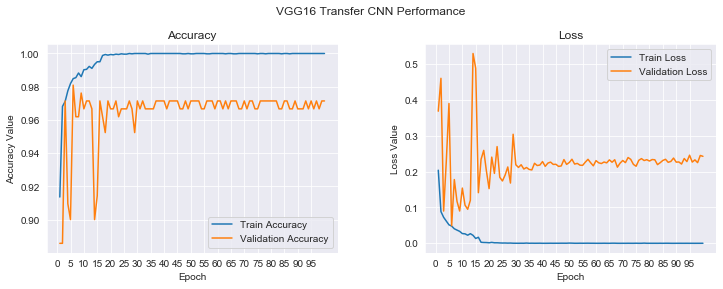

In [142]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Transfer CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 100, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 100, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [143]:
model.save_weights("pneumonia_weights.h5")

In [144]:
# Create vgg19 model
vggModel = VGG19(weights="pneumonia_weights.h5", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Add layers to model
outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

# Set the correct inputs and outputs to the model
vgg_model = Model(inputs=vggModel.input, outputs=outputs)

# Set the layers to frozen to keep the weights already made
for layer in vggModel.layers:
    layer.trainable = False

# Compile the model
vgg_model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

# Augment the data
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


# Return summary of model
vgg_model.summary()

# Plot model architecture
plot_model(vgg_model, show_shapes=True, show_layer_names=True)

# Import callbacks to adjust and save models while training
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Create ModelCheckpoint for callbacks
# autosave best Model
best_model_file = "vgg.h5"
best_model = ModelCheckpoint(
    best_model_file, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=4,
    min_lr=10e-7)

# Fit our model, and define the number of epochs and steps per epoch
history = vgg_model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=50,
                    verbose=2,
                    callbacks=[best_model, rlrop]
                    )

# Create predictions for the model
y_pred = vgg_model.predict(X_test, batch_size=32)
y_pred_covid = vgg_model.predict(covid_x_test, batch_size=32)

# Encode the labels of our test data
y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

# Generate a confusion matrix displaying the performance of the model
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
cm

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, cmap='Spectral', colorbar=True, figsize=(10, 10))
plt.show()

# Generate classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

ValueError: You are trying to load a weight file containing 3 layers into a model with 16 layers.

In [ ]:
end = datetime.datetime.now()
elapsed = end - original_start
print('Entire notebook took a total of:\n {}'.format(elapsed))

# iNterpret

After modeling our data, our results demonstrate that we were not able to meet the evaluation standards set. Our best and only model able to recognize the Covid-19 positive cases was VGG19. While this model exceeded the accuracy criteria with 0.97 accuracy, it failed to meet the recall objective with a 0.58 recall score. 

Q2. What is Selection Bias?
Selection bias is a kind of error that occurs when the researcher decides who is going to be studied. It is usually associated with research where the selection of participants isn’t random. It is sometimes referred to as the selection effect. It is the distortion of statistical analysis, resulting from the method of collecting samples. If the selection bias is not taken into account, then some conclusions of the study may not be accurate.

The types of selection bias include:

Sampling bias: It is a systematic error due to a non-random sample of a population causing some members of the population to be less likely to be included than others resulting in a biased sample.

Time interval: A trial may be terminated early at an extreme value (often for ethical reasons), but the extreme value is likely to be reached by the variable with the largest variance, even if all variables have a similar mean.

Data: When specific subsets of data are chosen to support a conclusion or rejection of bad data on arbitrary grounds, instead of according to previously stated or generally agreed criteria.

Attrition: Attrition bias is a kind of selection bias caused by attrition (loss of participants) discounting trial subjects/tests that did not run to completion.

# Conclusion

In conclusion, while the goal of creating visualizations that may be of use to the medical research community was achieved, we were not able to meet the FDA standards for Covid-19 testing. The most likely cause of this is due to the limited and bias nature of the data available during testing. 